# Please run this notebook in multi-ants-tracking conda environment!
Import libraries
Tutorial: https://blog.roboflow.com/how-to-train-detectron2/
https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

In [1]:
%load_ext autoreload
%autoreload

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import os
# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

#from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

import sys
import glob
from detectron2.structures import BoxMode

import tqdm


from MyTrainer import MyTrainer
from LossEvalHook import LossEvalHook

from detectron2.engine import DefaultTrainer
## make sure that the model validates agaisnt the val dataset, which is not defautl in the defaulttrainer class
class CocoTrainer(DefaultTrainer):
    

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):

        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)


** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# load JSON dataset into python dictionary

In [4]:
dataset_dicts ={}
import json
for d in["train","val"]:
    with open('/media/linx123-rtx/Elements/Render/YOLO custom dataset aligned (copy)/'+d+'.json', 'r') as fp:
        dataset_dicts[d] = json.load(fp)

for d in["train","val"]:
    for dic in dataset_dicts[d]:
        for anno in dic["annotations"]:
            if anno["bbox_mode"] == 0:
                anno["bbox_mode"] = BoxModeXYXY_ABS
            if anno["bbox_mode"] == 1:
                anno["bbox_mode"] = BoxMode.XYWH_ABS
            if anno["bbox_mode"] == 2:
                anno["bbox_mode"] = BoxMode.XYXY_REL
            if anno["bbox_mode"] == 3:
                anno["bbox_mode"] = BoxMode.XYWH_REL
            if anno["bbox_mode"] == 4:
                anno["bbox_mode"] = BoxMode.XYWHA_ABS

# Register detectron2 custom dataset

In [5]:
for d in ["train", "val"]:
    DatasetCatalog.register("bumblebee_" + d, lambda d=d: dataset_dicts[d])
    MetadataCatalog.get("bumblebee_" + d).set(thing_classes=["bumblebee"])
bumblebee_metadata = MetadataCatalog.get("bumblebee_train")

# visualizing random imgs of registration for validation

In [28]:

for d in random.sample(dataset_dicts["val"], 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=bumblebee_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2.imshow('window',out.get_image()[:, :, ::-1])
    cv2.waitKey()
    cv2.destroyAllWindows()

# prepare config and start training
commands : https://github.com/facebookresearch/Detectron/blob/master/detectron/core/config.py

In [ ]:
#from detectron2.engine import DefaultTrainer

def get_N():
    N = 0
    for img in DatasetCatalog.get("bumblebee_train"):
        N+=len(img["annotations"] )
    return N


# CALCULATE ITERATIONS OUT OF EPOCHS
EPOCHS = 10 #epochs
BS = 128 #128, batch size (between 2...2^n...512, smaller batch sizes are better suited to smaller learning rates)
N = get_N()
I = round((N / BS) * EPOCHS) # iterations

## LOAD CONFIG
cfg = get_cfg()
# lookup the config file in /home/linx123-rtx/.local/share/Trash/files/detectron2/configs
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
## DEFINE DATASET IN CONFIG
cfg.DATASETS.TRAIN = ('bumblebee_train',)
cfg.DATASETS.TEST = ('bumblebee_val',)
cfg.DATASETS.TESTBATCH = ('bumblebee_valbatch',)
cfg.DATALOADER.NUM_WORKERS = 4
## MODEL
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = BS 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (bumblebee).

## SOLVER
cfg.SOLVER.BASE_LR = 0.01  # good learning rate is 0.0005 for this case, 0.000015 is to high (common is between 10^-6...1)
cfg.SOLVER.LR_POLICY = 'steps_with_decay' #lr smoothly decays from SOLVER.BASE_LR to SOLVER.GAMMA * SOLVER.BASE_LR
cfg.SOLVER.GAMMA = 0.1 #0.01
cfg.SOLVER.STEPS = [0, I/EPOCHS*5, I/EPOCHS*(16),I/EPOCHS*(32),I/EPOCHS*(96)]
#cfg.SOLVER.LRS = [0.01, 0.0001, 0.00001,0.000001] # [0.000075, 0.000005, 0.000001,0.0000005]
cfg.SOLVER.WARMUP_ITERS = 500 #reduce effect of early training examples
# Start the warm up from SOLVER.BASE_LR * SOLVER.WARM_UP_FACTOR
cfg.SOLVER.WARM_UP_FACTOR = 1.0 / 3.0
# WARM_UP_METHOD can be either 'constant' or 'linear' (i.e., gradual)
cfg.SOLVER.WARM_UP_METHOD = 'linear'
cfg.SOLVER.MAX_ITER = I   #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.MOMENTUM = 0.9 # Momentum to use with SGD
cfg.SOLVER.IMS_PER_BATCH = 4 # IMS_PER_BATCH = 2 means that in 1 iteration the model sees 2 images

## TEST CONFIGS
cfg.TEST.EVAL_PERIOD = 10

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Loading config /home/linx123-rtx/anaconda3/envs/multi-ants-tracking/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[01/06 10:35:08 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

[01/06 10:35:08 d2.data.build]: Removed 88 images with no usable annotations. 11359 images left.
[01/06 10:35:09 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| bumblebee  | 15624        |
|            |              |
[01/06 10:35:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/06 10:35:09 d2.data.build]: Using training sampler TrainingSampler
[01/06 10:35:09 d2.data.common]: Serializing 11359 elements to byte tensors and concatenating them all ...
[01/06 10:35:09 d2.data.common]: Serialized dataset takes 4.13 MiB
[01/06 10:35:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/06 10:35:09 d2.data.build]: 

[01/06 10:38:54 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:51 (0.039025 s / img per device, on 1 devices)
[01/06 10:38:54 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/06 10:38:54 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[01/06 10:38:55 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.37 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | ma

# Plot Training 

In [5]:

# Look at training curves in tensorboard:
%reload_ext tensorboard
%tensorboard --logdir output --host localhost --port 8088


Reusing TensorBoard on port 8088 (pid 2992), started 9:58:13 ago. (Use '!kill 2992' to kill it.)

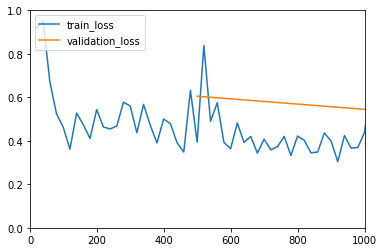

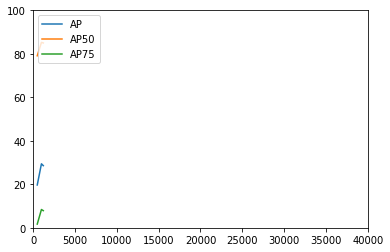

In [9]:
%run -i 'PlotTogether.py'

# run network on validation dataset

In [49]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 1000000  # set a custom testing threshold
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.4
predictor = DefaultPredictor(cfg)

# Visualize random

In [50]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(dataset_dicts["val"], 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=bumblebee_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imshow(os.path.basename(d["file_name"]),out.get_image()[:, :, ::-1])
    cv2.waitKey()
    cv2.destroyAllWindows()

tuple